In [12]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

In [13]:
#Processing parameters
potato_data_dir='data_raw\\robot_measurement\\potato\\measurement_3\\'
robot_data_dir='data_raw\\robot_measurement\\robot_log\\log4.txt'
output_folder='data_raw\\robot_measurement\\combined\\'

# Processing potato measurements
## Reading data

In [14]:
filenames = os.listdir(potato_data_dir)
header=["ACC_X","ACC_Y","ACC_Z","QUAT_W","QUAT_X","QUAT_Y","QUAT_Z","t1","t2","t3"]
df_potato = pd.DataFrame()

for file in filenames:
    df_tmp = pd.read_csv(potato_data_dir + file, sep='\t', names=header) #Read data file
    df_potato = df_potato.append(df_tmp, ignore_index=True)
del df_tmp

df_potato['t'] = df_potato.apply(lambda x: (x['t1']+x['t2']+x['t3'])/3, axis=1) #Use single timestamp for each data
df_potato.drop(columns=['t1', 't2', 't3'], inplace=True) #Drop unnessessary columns                    
print("Data shape"+ str(df_potato.shape))
df_potato

Data shape(99392, 8)


ACC_X  ACC_Y  ACC_Z   QUAT_W  QUAT_X  QUAT_Y  QUAT_Z             t
0      ___TURN___    NaN    NaN      NaN     NaN     NaN     NaN           NaN
1             351  148.0  204.0 -11681.0   198.0    37.0  -304.0  1.193181e+08
2             351  148.0  204.0 -11679.0   294.0    40.0  -400.0  1.193245e+08
3             180 -185.0 -226.0 -11679.0   294.0    40.0  -400.0  1.193321e+08
4             105  -82.0   50.0 -11675.0   398.0    43.0  -503.0  1.193407e+08
...           ...    ...    ...      ...     ...     ...     ...           ...
99387         131   38.0 -166.0 -11185.0   874.0   120.0  -808.0  9.499294e+08
99388         304  -25.0 -144.0 -11185.0   874.0   120.0  -808.0  9.499371e+08
99389         224    9.0 -210.0 -11183.0   898.0   121.0  -831.0  9.499434e+08
99390         224    9.0 -210.0 -11183.0   898.0   121.0  -831.0  9.499497e+08
99391          21 -146.0 -147.0 -11180.0   926.0   122.0  -861.0  9.499572e+08

[99392 rows x 8 columns]

## Finding rounds in the data

In [15]:
rounds_potato=[]
startpos_df=df_potato[df_potato["ACC_X"]=="___TURN___"]
separators=startpos_df.index

df_potato = df_potato.dropna()
df_potato=df_potato[df_potato["t"]>0]

for i in range(1,len(separators)):
    df_tmp=df_potato.iloc[separators[i-1]:separators[i]].copy()
    tmin=np.min(df_tmp['t'])
    tmax=np.max(df_tmp['t'])
    df_tmp['t_norm'] = df_tmp.apply(lambda x: (x['t']-tmin)/(tmax-tmin), axis=1)
    df_tmp['t']=df_tmp['t'].astype(int)
    rounds_potato.append(df_tmp)
print("Found " + str(len(rounds_potato)) + " rounds of data")

Found 95 rounds of data


# Processing robot measurements
## Reading data

In [16]:
with open(robot_data_dir) as f:
    robot_data = json.load(f)
    
temp = {}
data_iter = tqdm(enumerate(robot_data), desc='Reading data',total=len(robot_data))
df_robot = pd.DataFrame(columns=['X_pos','Y_pos', 'Y_pos', 't_r'])

for i, data in data_iter:
    temp[i]={'X_pos': data['p']['X'],
                 'Y_pos': data['p']['Y'],
                 'Z_pos': data['p']['Z'],
                 't_r': data['time']}

df_robot = pd.DataFrame.from_dict(temp, orient='index')
del temp, robot_data
df_robot

Reading data:   0%|          | 0/77255 [00:00<?, ?it/s]

X_pos             Y_pos             Z_pos            t_r
0       120.38643858212  300.322547005115  420.061051151364  1620226397007
1      123.724241280002  300.326009773792   420.06265687079  1620226397020
2      127.062639004765  300.331044351894  420.072243930497  1620226397030
3      130.406547247305  300.329496472922  420.081894687576  1620226397043
4      134.866391692431  300.335208213682  420.091525452977  1620226397058
...                 ...               ...               ...            ...
77250  224.909308856084  296.287851963732  420.099817148052  1620227296877
77251  224.906586581729  296.290008241107  420.099817148052  1620227296890
77252  224.906349861322  296.290131518953  420.099817148052  1620227296903
77253  224.906375239885  296.290131518953  420.099817148052  1620227296917
77254  224.906468221543  296.289352866592  420.099817136744  1620227296929

[77255 rows x 4 columns]

## Visualizing the data

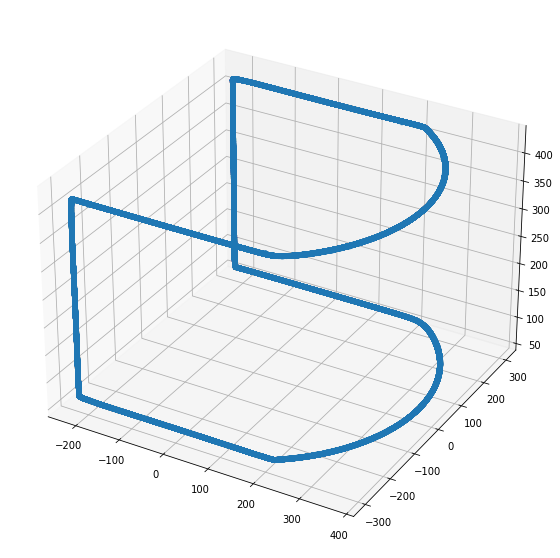

In [21]:
posx=np.array(df_robot["X_pos"].astype("float"))
posy=np.array(df_robot["Y_pos"].astype("float"))
posz=np.array(df_robot["Z_pos"].astype("float"))

plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(posx, posy, posz)

## Finding rounds in the data

In [7]:
startpos=np.array([-220, 300, 65])

def start_dist(posx, posy, posz, startpos):
    return np.sqrt((posx-startpos[0])**2+(posy-startpos[1])**2+(posz-startpos[2])**2)

def find_startpos(posx, posy, posz, startpos, it):
    print("Finding best points for syncronization...")
    d_start=start_dist(posx, posy, posz, startpos)
    cand = np.where(d_start <5)[0]
    print("Found " + str(cand.shape[0]) + " close points")
    for it in range(it):
        to_del=[]
        for i in np.arange(1,cand.shape[0]):
            if cand[i-1]+25>cand[i]:
                dist1=start_dist(posx[cand[i-1]], posy[cand[i-1]], posz[cand[i-1]], startpos)
                dist2=start_dist(posx[cand[i]], posy[cand[i]], posz[cand[i]], startpos)
                if dist1>dist2:
                    to_del.append(i-1)
                else:
                    to_del.append(i)   
        cand = np.delete(cand, to_del)
        print("deleted " + str(len(to_del)) + " duplicate")
    print("Found " + str(cand.shape[0]) + " syncronization points")
    return cand

Finding best points for syncronization...
Found 780 close points
deleted 676 duplicate
deleted 0 duplicate
deleted 0 duplicate
Found 104 syncronization points
[  566  1295  2031  2754  3486  4217  4956  5682  6416  7143  7871  8599
  9327 10061 10797 11547 12296 13044 13786 14528 15284 16037 16770 17505
 18239 18972 19705 20432 21168 21896 22621 23367 24109 24853 25608 26359
 27109 27856 28600 29356 30109 30863 31616 32365 33116 33857 34605 35360
 36107 36850 37601 38348 39094 39844 40590 41340 42091 42836 43589 44343
 45097 45848 46598 47348 48095 48839 49588 50331 51074 51821 52514 53271
 54004 54750 55508 56210 56960 57717 58472 59224 59975 60727 61473 62219
 62911 63658 64393 65137 65878 66626 67370 68111 68868 69620 70375 71123
 71879 72621 73367 74116 74822 75528 76276 77022]


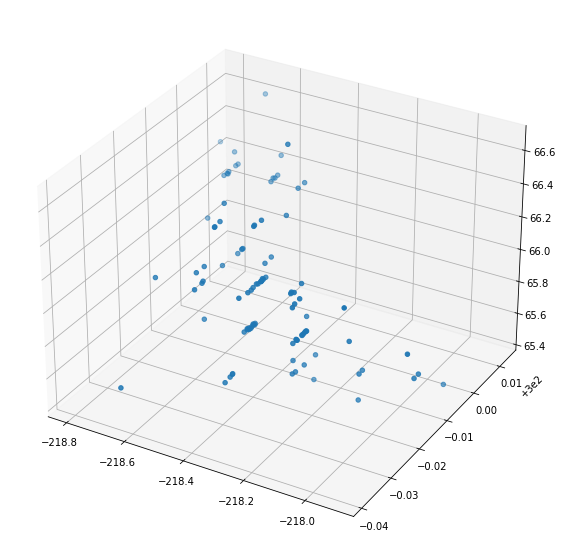

In [8]:
separators_robot=find_startpos(posx, posy, posz, startpos,3)
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(posx[separators_robot], posy[separators_robot], posz[separators_robot]);
print(separators_robot)

In [9]:
separators_robot=separators_robot[-len(rounds_potato)-1:]
rounds_robot=[]

for i in range(1,len(separators_robot)):
    df_tmp=df_robot.iloc[separators_robot[i-1]:separators_robot[i]].copy()
    tmin=np.min(df_tmp['t_r'].astype("float"))
    tmax=np.max(df_tmp['t_r'].astype("float"))
    df_tmp['t_norm'] = df_tmp.apply(lambda x: (float(x['t_r'])-tmin)/(tmax-tmin), axis=1)
    rounds_robot.append(df_tmp)
print("Found " + str(len(rounds_robot)) + " rounds of data")

Found 95 rounds of data


# Combining and saving data

In [10]:
save_iter = trange(len(rounds_robot), desc='Saving data')
for i in save_iter:
    df_tmp_potato=rounds_potato[i]
    df_tmp_robot=rounds_robot[i]
    
    df_tmp_merged=pd.merge_asof(df_tmp_robot, df_tmp_potato, on="t_norm", direction="nearest")
    df_tmp_merged.drop(columns=['t_r', 't_norm'], inplace=True)
    df_tmp_merged=df_tmp_merged[['ACC_X','ACC_Y','ACC_Z','QUAT_W','QUAT_X','QUAT_Y','QUAT_Z','X_pos','Y_pos', "Z_pos",'t']]
    
    output_name="Robot_round_data_" + str(i+1).zfill(2) +'.csv'
    df_tmp_merged.to_csv(output_folder + output_name, index=False)

Saving data:   0%|          | 0/95 [00:00<?, ?it/s]